In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 7.24 MiB/s, done.


In [2]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [3]:
# p 는 pickled 파일로 파이썬 객체를 바이너리 형태로 저장한다고 보면 됨. 불러오기 등에서 효율이 좋음.
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd # 데이터 사이언스에서 자주 쓰이는 라이브러리. csv파일을 가져올때 쓰인다.
import random

In [4]:
np.random.seed(0)

In [5]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f) # unpickling process as dictionary
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape) # 사진 갯수, height, width, depth(컬러 채널)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

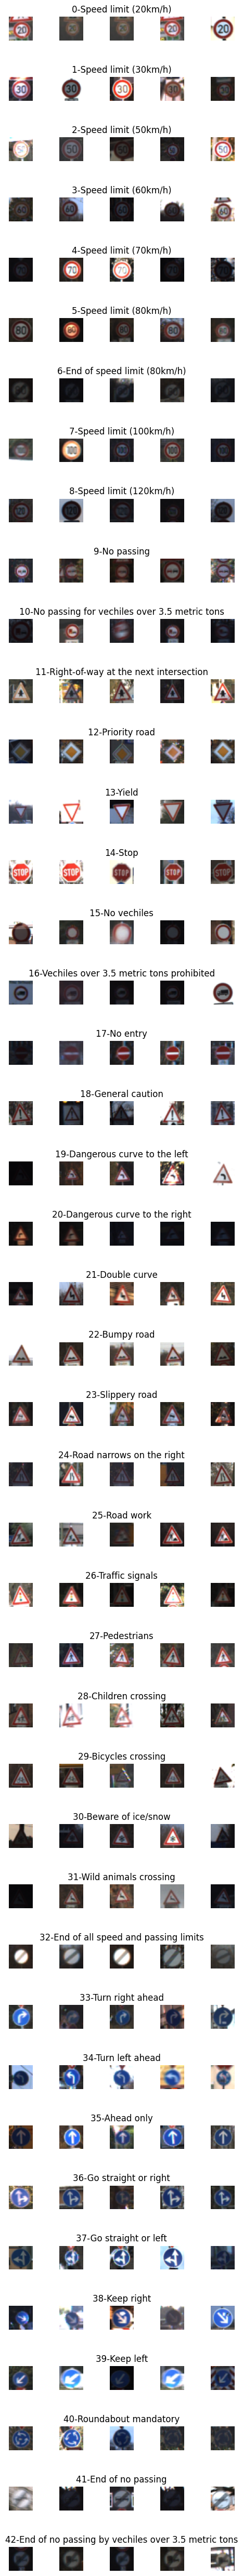

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43 # 43개의 traffic signs가 있음
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows(): # (index, Series) 형태로 받아옴. Index 는 말그대로 순서 index, Series 는 1-d array 로 관련 정보를 담고 있음(ex. sign name etc.)
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


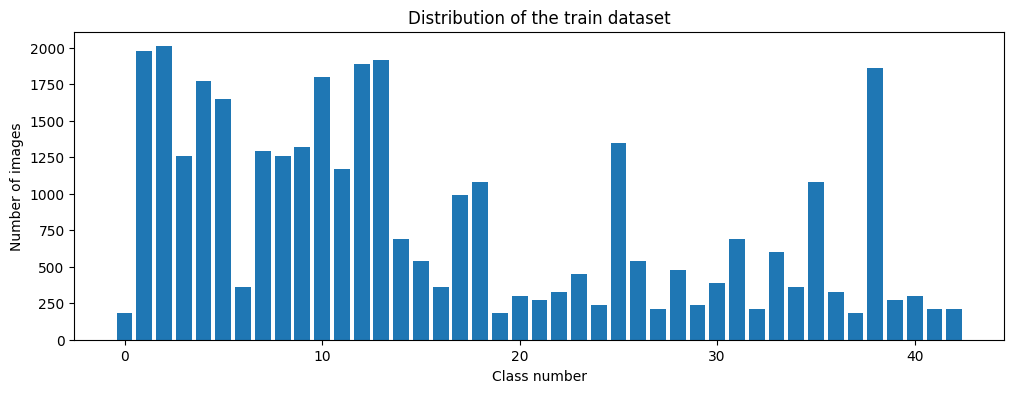

In [9]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


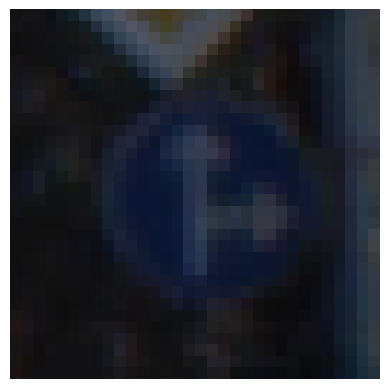

In [10]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


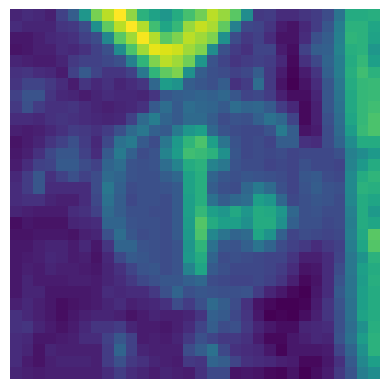

In [11]:
def grayscale(img): # 컬러는 중요한 feature이 아니므로 grayscale로 변환. 그림자에 따라 색도 변하고, 비슷한 색을 가지고 있는 표지판도 많기에 배제함. 또한 연산도 많이 줄음.
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


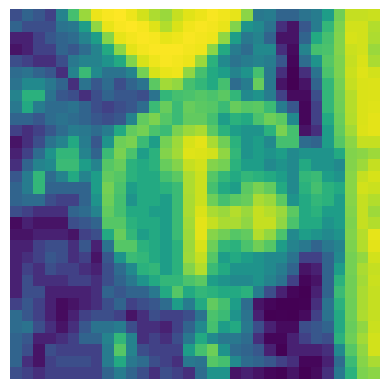

In [12]:
# histogram equalization : preprocessed가 안된 raw이미지면 pixel intensity(픽셀 밝기)가 한곳에 집중되어 있는 현상이 있을 수가 있음. 이것을 equally distributed 하게 만드는 작업임. 따라서 처리후의 이미지는 명암이 더 확고해지고
# pixel intensity는 더 넓게 벌어진다. feature을 더 쉽게 추출해 낼 수 있다.
def equalize(img):
  img = cv2.equalizeHist(img) # 이 함수는 grayscale만 받음.
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [13]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255 # normalization 0 ~ 255 는 sigmoid나 softmax 계산도중 너무 큰 값이 나오므로(ex. e^255) 0 ~ 1 사이의 작은 숫자로 만듬.
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


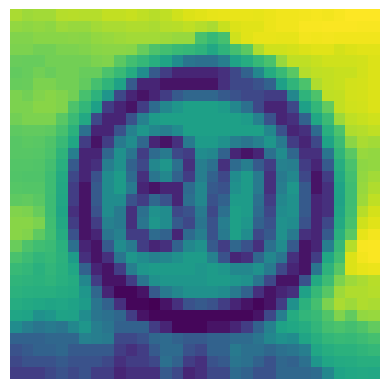

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [15]:
X_train = X_train.reshape(34799, 32, 32, 1) # CNN은 depth값이 필요하므로(각 depth마다 kernel이 돌아감) detph 1을 추가해줌.
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [16]:
# data augmentation: 기존에 있던 training sets의 이미지들을 확대, rotation등의 변환을 거쳐 새로운 데이터를 만들어내는 기법. 이로인해 부족한 training set을 보강해주는 것은 물론 새로운 이미지의 prediction
# 또한 정교해진다.
from keras.preprocessing.image import ImageDataGenerator
# 5 종류의 변환을 적
datagen = ImageDataGenerator(width_shift_range=0.1, # width : 0 과 1사이의 값은 사진의 몇퍼센트를 좌우로 움직일건지를 말함. 1을 초과하면 픽셀수를 의미함.
                   height_shift_range=0.1, # height : width와 동일
                   zoom_range=0.2, # 몇퍼센트 줌아웃, 줌인 시킬건지를 명시. 0.2는 오리지널 이미지의 0.8크기와 1.2 로 변환됨.
                   shear_range=0.1, # shear degree를 명시. 작은 값이 더 잘될 수 있음. 단위는 radian이 아닌 degree
                   rotation_range=10) # 회전각도를 명시. 단위는 degree

datagen.fit(X_train) # runtime일때 데이터를 반환한다. small portion만 반환해줌. input으로 들어오는 모든 이미지를 변환하면 inefficient 하므로.

(15, 32, 32, 1)


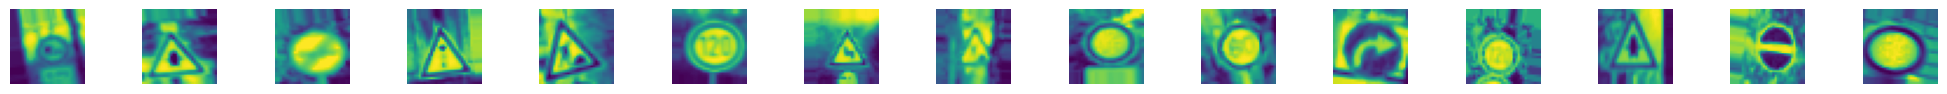

In [17]:
batches = datagen.flow(X_train, y_train, batch_size=15) # 이게 바로 request를 하고 이미지를 받는 iterator을 생성하는 함. batch_size는 이미지 갯수를 의미
X_batch, y_batch = next(batches) # next를 부를 때마다 새로운  20개의 이미지를 받음.

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')
print(X_batch.shape)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [19]:
y_train = to_categorical(y_train, 43) # 카테고리의 대소관계를 없애기 위한 one-hot encoding (1 -> 001, 2 -> 010, 3 -> 100 형태)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [20]:
def modified_model(): # 기존의 lenet 모델에서 convolutional layer을 추가함으로써 커스텀 모델을 만듬.
  model = Sequential()
  # 최적화 2번째 : 필터의 갯수를 늘리면 성능이 올라갈 가능성이 있음. 30 -> 60
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  # 최적화 3번째 : convolutional layer을 추가. input shape는 지정할 필요 없
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu')) # 3 * 3 * 30 *15 + 15 = 4065 adjustable한 parameters
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # 최적화 4번째 : Dropout layer을 추가함으로써 Overfitting을 방지할 수 있다.
  # model.add(Dropout(0.5))

  model.add(Flatten()) # 6 * 6 * 15 = 540 nodes
  model.add(Dense(500, activation='relu')) # 500 is arbitrary size
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  # 최적화 1번째 : Adam 컴파일러는 learning rate를 단계적으로 수정하지만 최적화를하려면 첫번째 값도 매우 중요함. 0.01 -> 0.001
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [21]:
model = modified_model()
print(model.summary())
# Convolutional layers를 추가하면 오히려 총 parameters의 갯수는 줄어든다. 그 이유는 convolution을 거치면서 이미지 사이즈가 줄어들고 dense layer에 도착할 즈음에는 많이 줄기 때문.
# 직관과는 다르게 오히려 less computing power과 더 높은 결과를 보여줄 수 있다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=X_train.shape[0]/50, epochs=15, validation_data=(X_val, y_val), shuffle = 1)
# step_per_epoch는 각 epoch마다 batch를 몇개 생성할지를 결정.

Epoch 1/15
695/695 [==============================] - 25s 25ms/step - loss: 1.6958 - accuracy: 0.5135 - val_loss: 0.2870 - val_accuracy: 0.9159
Epoch 2/15
695/695 [==============================] - 17s 25ms/step - loss: 0.5786 - accuracy: 0.8240 - val_loss: 0.1745 - val_accuracy: 0.9456
Epoch 3/15
695/695 [==============================] - 18s 25ms/step - loss: 0.3734 - accuracy: 0.8841 - val_loss: 0.0900 - val_accuracy: 0.9746
Epoch 4/15
695/695 [==============================] - 17s 25ms/step - loss: 0.2795 - accuracy: 0.9137 - val_loss: 0.0715 - val_accuracy: 0.9789
Epoch 5/15
695/695 [==============================] - 17s 25ms/step - loss: 0.2279 - accuracy: 0.9304 - val_loss: 0.0576 - val_accuracy: 0.9834
Epoch 6/15
695/695 [==============================] - 25s 36ms/step - loss: 0.1976 - accuracy: 0.9363 - val_loss: 0.0582 - val_accuracy: 0.9821
Epoch 7/15
695/695 [==============================] - 18s 26ms/step - loss: 0.1718 - accuracy: 0.9456 - val_loss: 0.0490 - val_accuracy:

Text(0.5, 0, 'epoch')

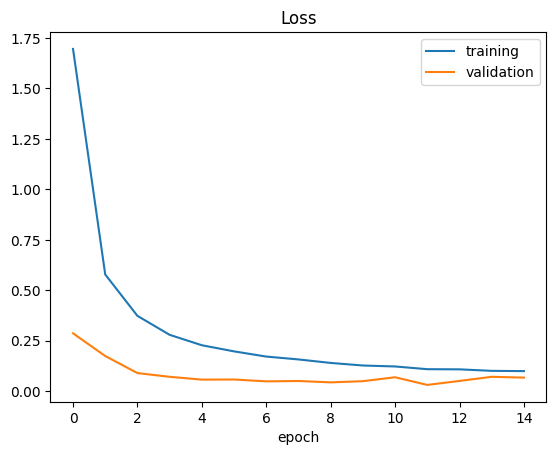

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

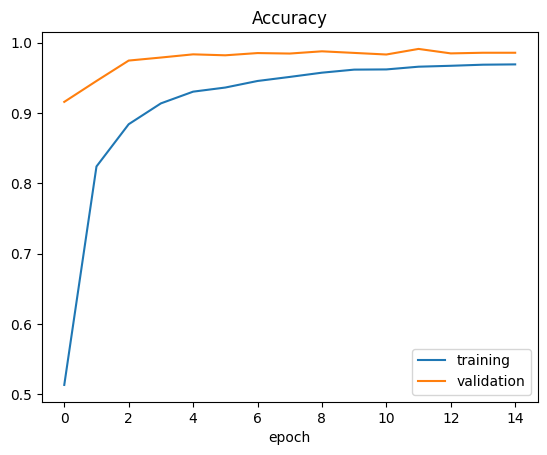

In [24]:
# validation accuracy가 training accuracy 보다 확연히 낮으면 Overfitting이라는 것.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [25]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy', score[1])

Test Score: 0.13874001801013947
Test Accuracy 0.9619160890579224


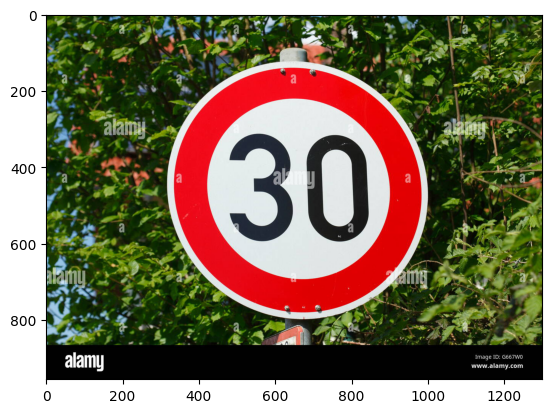

In [26]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


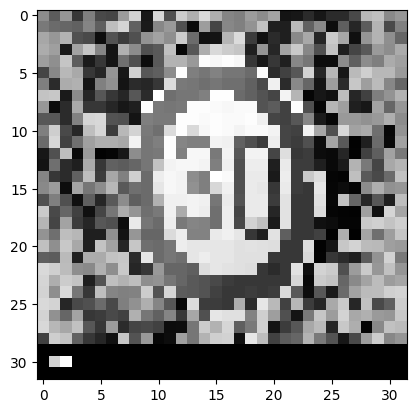

In [27]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [28]:
img = img.reshape(1, 32, 32, 1)

In [29]:
prediction = np.argmax(model.predict(img),axis=1) 
print("predicted sign: "+ str(prediction))

1/1 [==============================] - 0s 248ms/step
predicted sign: [1]
